## Overview: Load and inspect the SMS Spam dataset
This cell performs the initial data-loading and inspection steps:
- Loads the `SMSSpamCollection` file using `pandas.read_csv` with `sep='	'` and no header,
  so we explicitly name the columns `label` and `message`.
- Displays the first 5 rows with `display(df.head())` to preview the data.
- Prints dataframe summary information using `df.info()` to show types and missing values.
- Prints the label distribution with `df['label'].value_counts()` to see how many messages are `ham` vs `spam`.
These steps help verify the file format and provide a quick sanity check before cleaning and feature engineering.

In [1]:
import pandas as pd

# The file is tab-separated (we saw 'ham\tGo...' in the file)
# It also doesn't have a header row, so we'll add column names.
file_path = 'SMSSpamCollection'
df = pd.read_csv(file_path, sep='\t', header=None, names=['label', 'message'])

# 1. See the first 5 rows
print("--- First 5 Rows ---")
display(df.head())

# 2. Get a summary of the data
print("\n--- Data Info ---")
df.info()

# 3. Check the distribution of ham vs. spam
print("\n--- Label Counts ---")
print(df['label'].value_counts())

--- First 5 Rows ---


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."



--- Data Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB

--- Label Counts ---
label
ham     4825
spam     747
Name: count, dtype: int64


## Clean duplicates and encode labels
This cell removes any duplicate rows, recreates a cleaned dataframe (`df_cleaned`), and encodes the `label` column into numeric form (`ham`→0, `spam`→1) so later models can consume the targets. It prints the cleaned shape plus the first few rows for verification.

In [2]:
# 1. Check for duplicate messages
duplicate_count = df.duplicated().sum()
print(f"--- Number of duplicate messages found: {duplicate_count} ---")

# 2. Remove duplicates
df_cleaned = df.drop_duplicates()

# 3. Encode the 'label' column
# We'll map 'ham' to 0 (not spam) and 'spam' to 1 (is spam)
df_cleaned['label_encoded'] = df_cleaned['label'].map({'ham': 0, 'spam': 1})

# 4. Display the results of our cleaning
print(f"\n--- Shape after removing duplicates: {df_cleaned.shape} ---")
print("\n--- First 5 rows of cleaned data ---")
display(df_cleaned.head())

# 5. Verify the new column and data types
print("\n--- Cleaned Data Info ---")
df_cleaned.info()

--- Number of duplicate messages found: 403 ---

--- Shape after removing duplicates: (5169, 3) ---

--- First 5 rows of cleaned data ---


C:\Users\nagar\AppData\Local\Temp\ipykernel_29416\2260172392.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['label_encoded'] = df_cleaned['label'].map({'ham': 0, 'spam': 1})


,label,message,label_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0



--- Cleaned Data Info ---
<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          5169 non-null   object
 1   message        5169 non-null   object
 2   label_encoded  5169 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 161.5+ KB


## Build text features
Imports NLTK/Scikit-learn helpers, defines the text preprocessing pipeline (lowercase, punctuation removal, stopword filtering, stemming), tests it on a sample message, and vectorizes the cleaned corpus with `CountVectorizer` to create the feature matrix used throughout the rest of the notebook.

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string

# --- Setup: Download NLTK data ---
# This only needs to be run once.
try:
    nltk.data.find('corpora/stopwords')
    print("Stopwords dictionary already downloaded.")
except LookupError:
    print("Downloading stopwords dictionary...")
    nltk.download('stopwords')


# --- 1. Define Features (X) and Target (y) ---
# We use .copy() to avoid the SettingWithCopyWarning
df_final = df_cleaned.copy()
X = df_final['message']
y = df_final['label_encoded']

print(f"--- X shape (features): {X.shape} ---")
print(f"--- y shape (target): {y.shape} ---")


# --- 2. Create Text Preprocessing Function ---
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def process_text(text):
    # 1. Convert to lowercase
    text = text.lower()
    
    # 2. Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # 3. Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # 4. Stem words
    words = [stemmer.stem(word) for word in words]
    
    # 5. Re-join words into a single string
    return ' '.join(words)

# --- Test the function ---
test_message = "Hi! This is a test message. We are running it to see the output!"
print(f"\n--- Original Message: {test_message} ---")
print(f"--- Processed Message: {process_text(test_message)} ---")


# --- 3. Apply CountVectorization ---

# Initialize the vectorizer, telling it to use our custom function
# max_features=5000 means it will only keep the top 5000 most common words.
cv = CountVectorizer(preprocessor=process_text, max_features=5000)
# cv = TfidfVectorizer(preprocessor=process_text, max_features=5000)

# Fit the vectorizer to our text data and transform the text into a matrix
X_cv = cv.fit_transform(X)

# --- 4. Check the results ---
print("\n--- Shape of our new CountVectorizer feature matrix (X) ---")
print(X_cv.shape)

print("\n--- Feature Engineering Complete ---")

Stopwords dictionary already downloaded.
--- X shape (features): (5169,) ---
--- y shape (target): (5169,) ---

--- Original Message: Hi! This is a test message. We are running it to see the output! ---
--- Processed Message: hi test messag run see output ---

--- Shape of our new CountVectorizer feature matrix (X) ---
(5169, 5000)

--- Feature Engineering Complete ---


## Split training and test sets
Uses `train_test_split` with stratification to maintain the ham/spam ratio, reports total samples, the shapes of train/test matrices, and the class balance in each split. This establishes the reusable `X_train`, `X_test`, `y_train`, and `y_test` objects.

In [4]:
from sklearn.model_selection import train_test_split

# --- 1. Set the test split percentage ---
# 0.2 means 20% for testing, 80% for training
TEST_PERCENTAGE = 0.2

# --- 2. Split the data ---
# We use X_cv from the previous step.
# random_state=42 ensures you get the same split every time you run this.
X_train, X_test, y_train, y_test = train_test_split(
    X_cv, 
    y, 
    test_size=TEST_PERCENTAGE, 
    random_state=42,
    stratify=y  # 'stratify=y' is important for imbalanced data. 
                  # It ensures both train and test sets have a similar 
                  # percentage of 'ham' and 'spam' as the original data.
)

# --- 3. Print the shapes of the new sets ---
print("--- Data Splitting Complete ---")
print(f"Total messages:    {X_cv.shape[0]}")
print(f"X_train shape:     {X_train.shape}  (Training features)")
print(f"y_train shape:     {y_train.shape}   (Training labels)")
print(f"X_test shape:      {X_test.shape}   (Testing features)")
print(f"y_test shape:      {y_test.shape}    (Testing labels)")

print("\n--- Training set label distribution: ---")
print(y_train.value_counts(normalize=True))
print("\n--- Testing set label distribution: ---")
print(y_test.value_counts(normalize=True))

--- Data Splitting Complete ---
Total messages:    5169
X_train shape:     (4135, 5000)  (Training features)
y_train shape:     (4135,)   (Training labels)
X_test shape:      (1034, 5000)   (Testing features)
y_test shape:      (1034,)    (Testing labels)

--- Training set label distribution: ---
label_encoded
0    0.873761
1    0.126239
Name: proportion, dtype: float64

--- Testing set label distribution: ---
label_encoded
0    0.873308
1    0.126692
Name: proportion, dtype: float64


## Min-max scale vectorized features
Converts the sparse count matrices to dense arrays, fits a `MinMaxScaler` on the training data, and scales both train and test sets so downstream algorithms that expect bounded numeric features can be compared to the unscaled baselines.

In [5]:
from sklearn.preprocessing import MinMaxScaler

# --- 1. Initialize the Scaler ---
# This scaler will make all feature values (word counts) 
# for each message fit between 0 and 1.
scaler = MinMaxScaler()

print("--- Scaling the CountVectorizer data... ---")

# --- 2. Fit and Transform the Training Data ---
# We fit AND transform the training data
# We use .toarray() because MinMaxScaler doesn't 
# efficiently handle sparse matrices in all cases.
# This will use more memory.
X_train_scaled = scaler.fit_transform(X_train.toarray())

# --- 3. Transform the Test Data ---
# We ONLY transform the test data (using the 'min' and 'max' 
# learned from the training data)
X_test_scaled = scaler.transform(X_test.toarray())

print("--- Scaling complete. ---")
print(f"Shape of X_train_scaled: {X_train_scaled.shape}")
print(f"Shape of X_test_scaled: {X_test_scaled.shape}")

--- Scaling the CountVectorizer data... ---
--- Scaling complete. ---
Shape of X_train_scaled: (4135, 5000)
Shape of X_test_scaled: (1034, 5000)


## Compare classifiers on scaled counts
Trains Logistic Regression, MultinomialNB, and BernoulliNB on the scaled matrices, prints accuracy/precision/confusion matrices, and saves a side-by-side heatmap image for quick visual comparison across the three algorithms.

--- Training Logistic Regression (MinMax Scaled)... ---
Logistic Regression (Scaled) Accuracy: 97.58% | Precision: 99.07%
Confusion Matrix:
[[902   1]
 [ 24 107]]

--- Training MultinomialNB (MinMax Scaled)... ---
MultinomialNB (Scaled) Accuracy: 97.58% | Precision: 92.06%
Confusion Matrix:
[[893  10]
 [ 15 116]]

--- Training BernoulliNB (MinMax Scaled)... ---
BernoulliNB (Scaled) Accuracy: 98.16% | Precision: 97.46%
Confusion Matrix:
[[900   3]
 [ 16 115]]

--- All Scaled plots saved as 'minmax_scaled_comparison_cm.png' ---


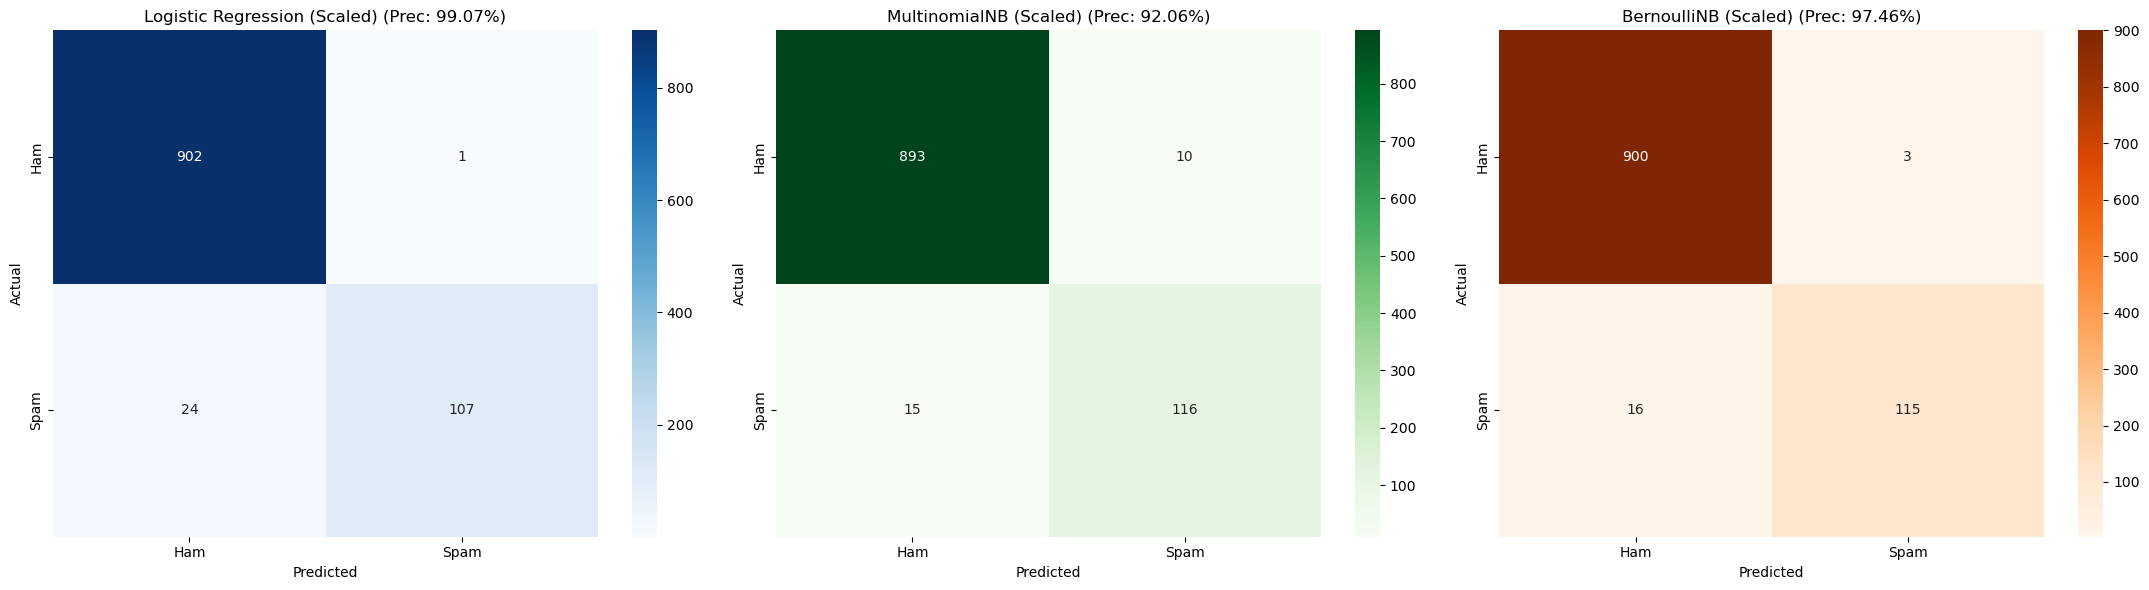

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Initialize all three models ---
log_reg_scaled = LogisticRegression(random_state=42, max_iter=1000)
mnb_scaled = MultinomialNB()
bnb_scaled = BernoulliNB()

# --- 2. Train and Evaluate ---

# Model 1: Logistic Regression on Scaled Data
print("--- Training Logistic Regression (MinMax Scaled)... ---")
log_reg_scaled.fit(X_train_scaled, y_train)
y_pred_lr_scaled = log_reg_scaled.predict(X_test_scaled)
acc_lr_scaled = accuracy_score(y_test, y_pred_lr_scaled)
pre_lr_scaled = precision_score(y_test, y_pred_lr_scaled)
cm_lr_scaled = confusion_matrix(y_test, y_pred_lr_scaled)
print(f"Logistic Regression (Scaled) Accuracy: {acc_lr_scaled*100:.2f}% | Precision: {pre_lr_scaled*100:.2f}%")
print(f"Confusion Matrix:\n{cm_lr_scaled}\n")

# Model 2: MultinomialNB on Scaled Data
print("--- Training MultinomialNB (MinMax Scaled)... ---")
mnb_scaled.fit(X_train_scaled, y_train)
y_pred_mnb_scaled = mnb_scaled.predict(X_test_scaled)
acc_mnb_scaled = accuracy_score(y_test, y_pred_mnb_scaled)
pre_mnb_scaled = precision_score(y_test, y_pred_mnb_scaled)
cm_mnb_scaled = confusion_matrix(y_test, y_pred_mnb_scaled)
print(f"MultinomialNB (Scaled) Accuracy: {acc_mnb_scaled*100:.2f}% | Precision: {pre_mnb_scaled*100:.2f}%")
print(f"Confusion Matrix:\n{cm_mnb_scaled}\n")

# Model 3: BernoulliNB on Scaled Data
print("--- Training BernoulliNB (MinMax Scaled)... ---")
bnb_scaled.fit(X_train_scaled, y_train)
y_pred_bnb_scaled = bnb_scaled.predict(X_test_scaled)
acc_bnb_scaled = accuracy_score(y_test, y_pred_bnb_scaled)
pre_bnb_scaled = precision_score(y_test, y_pred_bnb_scaled)
cm_bnb_scaled = confusion_matrix(y_test, y_pred_bnb_scaled)
print(f"BernoulliNB (Scaled) Accuracy: {acc_bnb_scaled*100:.2f}% | Precision: {pre_bnb_scaled*100:.2f}%")
print(f"Confusion Matrix:\n{cm_bnb_scaled}\n")


# --- 3. Plot all three Confusion Matrices ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6)) # 1 row, 3 columns

sns.heatmap(cm_lr_scaled, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f'Logistic Regression (Scaled) (Prec: {pre_lr_scaled*100:.2f}%)')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Ham', 'Spam']); axes[0].set_yticklabels(['Ham', 'Spam'])

sns.heatmap(cm_mnb_scaled, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f'MultinomialNB (Scaled) (Prec: {pre_mnb_scaled*100:.2f}%)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Ham', 'Spam']); axes[1].set_yticklabels(['Ham', 'Spam'])

sns.heatmap(cm_bnb_scaled, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title(f'BernoulliNB (Scaled) (Prec: {pre_bnb_scaled*100:.2f}%)')
axes[2].set_xlabel('Predicted'); axes[2].set_ylabel('Actual')
axes[2].set_xticklabels(['Ham', 'Spam']); axes[2].set_yticklabels(['Ham', 'Spam'])

plt.tight_layout()
plt.savefig('minmax_scaled_comparison_cm.png')
print("--- All Scaled plots saved as 'minmax_scaled_comparison_cm.png' ---")

## Baseline logistic regression (unscaled counts)
Runs Logistic Regression directly on the sparse count vectors to establish a baseline, reports accuracy/precision along with the confusion matrix, and stores a heatmap image for documentation.

--- Training the Logistic Regression model... ---
--- Model training complete. ---

Logistic Regression Accuracy: 97.97%
Logistic Regression Precision (Spam): 99.11%

--- Confusion Matrix (Logistic Regression) ---
[[902   1]
 [ 20 111]]

--- Confusion Matrix plot saved as 'logistic_regression_cm.png' ---


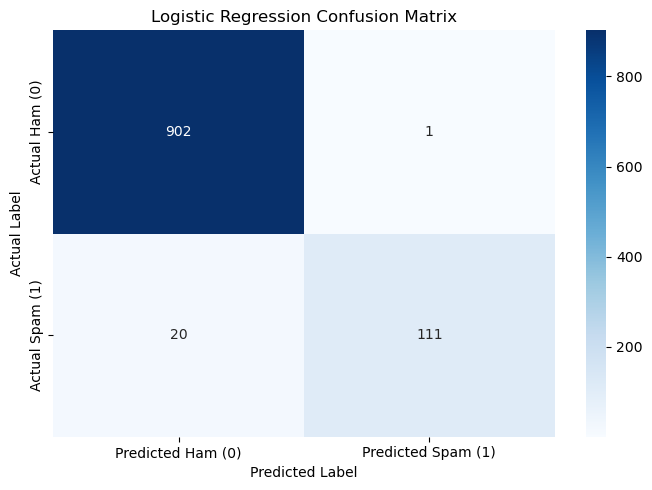

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Initialize and Train the Model ---
# We use random_state=42 for reproducibility
log_reg = LogisticRegression(random_state=42, max_iter=1000)

print("--- Training the Logistic Regression model... ---")
log_reg.fit(X_train, y_train)
print("--- Model training complete. ---")


# --- 2. Make Predictions ---
# Get the model's predictions on the test set
y_pred_lr = log_reg.predict(X_test)


# --- 3. Evaluate the Model ---
# Calculate Accuracy
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"\nLogistic Regression Accuracy: {accuracy_lr * 100:.2f}%")

# Calculate Precision
# 'pos_label=1' tells it we are interested in the 'spam' class
precision_lr = precision_score(y_test, y_pred_lr, pos_label=1)
print(f"Logistic Regression Precision (Spam): {precision_lr * 100:.2f}%")

# Calculate Confusion Matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("\n--- Confusion Matrix (Logistic Regression) ---")
print(cm_lr)


# --- 4. Plot the Confusion Matrix ---
# This gives us a nice visual of the results
plt.figure(figsize=(7, 5))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Ham (0)', 'Predicted Spam (1)'], 
            yticklabels=['Actual Ham (0)', 'Actual Spam (1)'])
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('logistic_regression_cm.png')
print("\n--- Confusion Matrix plot saved as 'logistic_regression_cm.png' ---")

## (Optional) SGDClassifier experiment stub
Placeholder for training an `SGDClassifier` with logistic loss on the TF-IDF data; the code is currently commented out but retained to quickly enable a linear classifier trained via stochastic gradient descent.

In [8]:
# from sklearn.linear_model import SGDClassifier
# from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # --- 1. Initialize and Train the Model ---
# # loss='log_loss' tells the model to perform Logistic Regression.
# # random_state=42 for reproducibility.
# sgd_model = SGDClassifier(loss='log_loss', random_state=42)

# print("--- Training the SGDClassifier (Logistic Regression)... ---")
# # We use the TF-IDF data because it is scaled
# sgd_model.fit(X_train, y_train)
# print("--- Model training complete. ---")


# # --- 2. Make Predictions ---
# y_pred_sgd = sgd_model.predict(X_test)


# # --- 3. Evaluate the Model ---
# # Calculate Accuracy
# accuracy_sgd = accuracy_score(y_test, y_pred_sgd)
# print(f"\nSGDClassifier Accuracy: {accuracy_sgd * 100:.2f}%")

# # Calculate Precision
# precision_sgd = precision_score(y_test, y_pred_sgd, pos_label=1)
# print(f"SGDClassifier Precision (Spam): {precision_sgd * 100:.2f}%")

# # Calculate Confusion Matrix
# cm_sgd = confusion_matrix(y_test, y_pred_sgd)
# print("\n--- Confusion Matrix (SGDClassifier) ---")
# print(cm_sgd)


# # --- 4. Plot the Confusion Matrix ---
# plt.figure(figsize=(7, 5))
# sns.heatmap(cm_sgd, annot=True, fmt='d', cmap='Purples',
#             xticklabels=['Predicted Ham (0)', 'Predicted Spam (1)'], 
#             yticklabels=['Actual Ham (0)', 'Actual Spam (1)'])
# plt.title('SGDClassifier (log_loss) Confusion Matrix')
# plt.ylabel('Actual Label')
# plt.xlabel('Predicted Label')
# plt.tight_layout()
# plt.savefig('sgd_classifier_cm.png')
# print("\n--- Confusion Matrix plot saved as 'sgd_classifier_cm.png' ---")

## Full Naive Bayes comparison
Converts sparse matrices to dense arrays for GaussianNB, then trains Multinomial, Gaussian, and Bernoulli variants, printing accuracy/precision plus confusion matrices and saving a 3-panel heatmap figure for reference.

--- Note: GaussianNB requires a dense matrix, which will use more memory. ---
--- Converting sparse data to dense array... ---
--- Data conversion complete. ---

--- Training MultinomialNB... ---
MultinomialNB Accuracy: 97.49% | Precision: 88.32%
Confusion Matrix:
[[887  16]
 [ 10 121]]

--- Training GaussianNB... ---
GaussianNB Accuracy: 86.75% | Precision: 48.73%
Confusion Matrix:
[[782 121]
 [ 16 115]]

--- Training BernoulliNB... ---
BernoulliNB Accuracy: 98.16% | Precision: 97.46%
Confusion Matrix:
[[900   3]
 [ 16 115]]

--- All Naive Bayes plots saved as 'naive_bayes_comparison_cm.png' ---


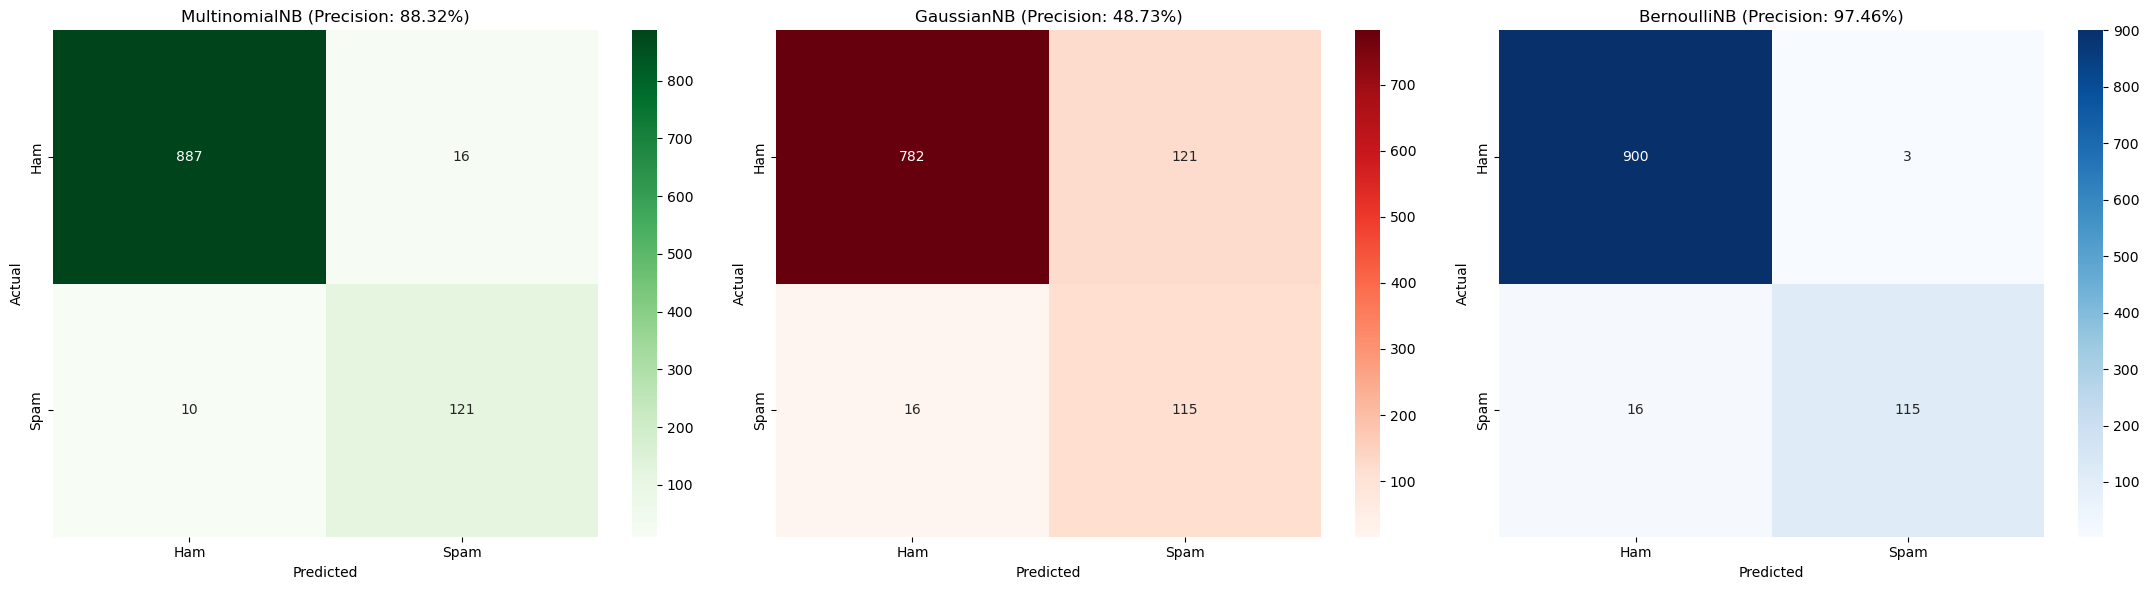

In [9]:
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- A heads-up about GaussianNB ---
print("--- Note: GaussianNB requires a dense matrix, which will use more memory. ---")
print("--- Converting sparse data to dense array... ---")
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()
print("--- Data conversion complete. ---")

# --- 1. Initialize all three models ---
mnb = MultinomialNB()
gnb = GaussianNB()
bnb = BernoulliNB()

# --- 2. Train and Evaluate ---

# Model 1: Multinomial (for counts)
print("\n--- Training MultinomialNB... ---")
mnb.fit(X_train, y_train)
y_pred_mnb = mnb.predict(X_test)
acc_mnb = accuracy_score(y_test, y_pred_mnb)
pre_mnb = precision_score(y_test, y_pred_mnb)
cm_mnb = confusion_matrix(y_test, y_pred_mnb)
print(f"MultinomialNB Accuracy: {acc_mnb*100:.2f}% | Precision: {pre_mnb*100:.2f}%")
print(f"Confusion Matrix:\n{cm_mnb}\n")

# Model 2: Gaussian (for continuous 'bell curve' data)
print("--- Training GaussianNB... ---")
gnb.fit(X_train_dense, y_train)
y_pred_gnb = gnb.predict(X_test_dense)
acc_gnb = accuracy_score(y_test, y_pred_gnb)
pre_gnb = precision_score(y_test, y_pred_gnb)
cm_gnb = confusion_matrix(y_test, y_pred_gnb)
print(f"GaussianNB Accuracy: {acc_gnb*100:.2f}% | Precision: {pre_gnb*100:.2f}%")
print(f"Confusion Matrix:\n{cm_gnb}\n")

# Model 3: Bernoulli (for binary 'yes/no' data)
print("--- Training BernoulliNB... ---")
bnb.fit(X_train, y_train)
y_pred_bnb = bnb.predict(X_test)
acc_bnb = accuracy_score(y_test, y_pred_bnb)
pre_bnb = precision_score(y_test, y_pred_bnb)
cm_bnb = confusion_matrix(y_test, y_pred_bnb)
print(f"BernoulliNB Accuracy: {acc_bnb*100:.2f}% | Precision: {pre_bnb*100:.2f}%")
print(f"Confusion Matrix:\n{cm_bnb}\n")


# --- 3. Plot all three Confusion Matrices ---
fig, axes = plt.subplots(1, 3, figsize=(22, 6)) # 1 row, 3 columns

sns.heatmap(cm_mnb, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title(f'MultinomialNB (Precision: {pre_mnb*100:.2f}%)')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
axes[0].set_xticklabels(['Ham', 'Spam']); axes[0].set_yticklabels(['Ham', 'Spam'])

sns.heatmap(cm_gnb, annot=True, fmt='d', cmap='Reds', ax=axes[1])
axes[1].set_title(f'GaussianNB (Precision: {pre_gnb*100:.2f}%)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')
axes[1].set_xticklabels(['Ham', 'Spam']); axes[1].set_yticklabels(['Ham', 'Spam'])

sns.heatmap(cm_bnb, annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title(f'BernoulliNB (Precision: {pre_bnb*100:.2f}%)')
axes[2].set_xlabel('Predicted'); axes[2].set_ylabel('Actual')
axes[2].set_xticklabels(['Ham', 'Spam']); axes[2].set_yticklabels(['Ham', 'Spam'])

plt.tight_layout()
plt.savefig('naive_bayes_comparison_cm.png')
print("--- All Naive Bayes plots saved as 'naive_bayes_comparison_cm.png' ---")

## Evaluate KNN baseline
Fits a `KNeighborsClassifier` (k=5) on the count vectors, reports accuracy/precision, prints the confusion matrix, and saves a single heatmap so we can compare instance-based performance to the probabilistic and linear models.

--- 'Training' the KNN model (memorizing data)... ---
--- Model 'training' complete. ---
--- Making predictions (this may take a moment)... ---
--- Predictions complete. ---

KNN Accuracy: 90.72%
KNN Precision (Spam): 97.30%

--- Confusion Matrix (KNN) ---
[[902   1]
 [ 95  36]]

--- Confusion Matrix plot saved as 'knn_cm.png' ---


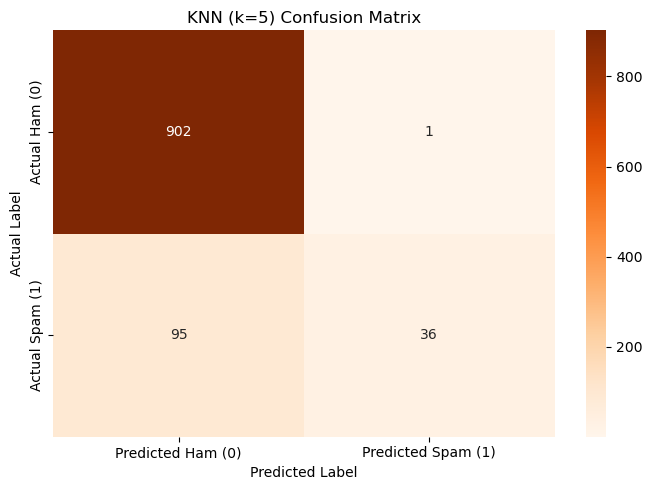

In [10]:
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Initialize and Train the Model ---
# We'll start with n_neighbors=5, a common default.
knn = KNeighborsClassifier(n_neighbors=5)

print("--- 'Training' the KNN model (memorizing data)... ---")
knn.fit(X_train, y_train)
print("--- Model 'training' complete. ---")


# --- 2. Make Predictions ---
# This step can be slow for KNN as it calculates distances
print("--- Making predictions (this may take a moment)... ---")
y_pred_knn = knn.predict(X_test)
print("--- Predictions complete. ---")


# --- 3. Evaluate the Model ---
# Calculate Accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"\nKNN Accuracy: {accuracy_knn * 100:.2f}%")

# Calculate Precision
precision_knn = precision_score(y_test, y_pred_knn, pos_label=1)
print(f"KNN Precision (Spam): {precision_knn * 100:.2f}%")

# Calculate Confusion Matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("\n--- Confusion Matrix (KNN) ---")
print(cm_knn)


# --- 4. Plot the Confusion Matrix ---
plt.figure(figsize=(7, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Predicted Ham (0)', 'Predicted Spam (1)'], 
            yticklabels=['Actual Ham (0)', 'Actual Spam (1)'])
plt.title('KNN (k=5) Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('knn_cm.png')
print("\n--- Confusion Matrix plot saved as 'knn_cm.png' ---")

## Logistic regression with class balancing
Retrains Logistic Regression using `class_weight='balanced'` to penalize misclassified spam messages, compares its confusion matrix and precision against the earlier baseline, and saves an updated heatmap.

--- Training the BALANCED Logistic Regression model... ---
--- Model training complete. ---

--- COMPARISON OF RESULTS ---

--- Original LogisticRegression (C=1.0) ---
Precision: 99.11%
False Positives: 1  | False Negatives: 20
[[902   1]
 [ 20 111]]

--- NEW LogisticRegression (class_weight='balanced') ---
Precision: 94.40%
False Positives: 7  | False Negatives: 13
[[896   7]
 [ 13 118]]

--- New balanced model plot saved as 'balanced_logistic_regression_cm.png' ---


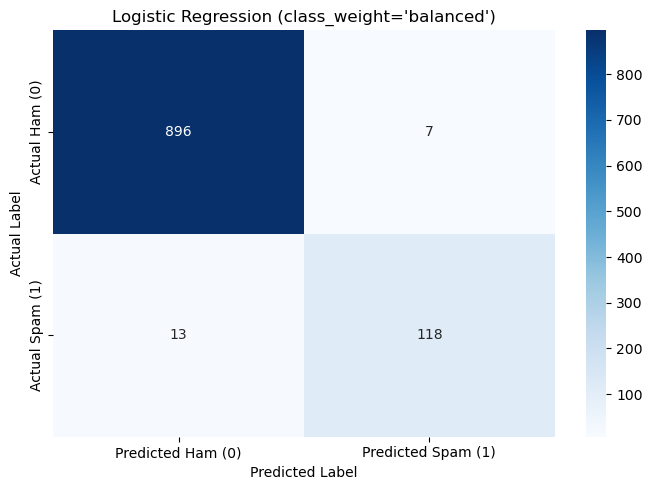

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Initialize and Train the NEW Balanced Model ---
# We use our original CountVec data (X_train, y_train)
lr_balanced = LogisticRegression(
    class_weight='balanced',  # This is the new parameter
    random_state=42, 
    max_iter=1000
)

print("--- Training the BALANCED Logistic Regression model... ---")
lr_balanced.fit(X_train, y_train)
print("--- Model training complete. ---")


# --- 2. Make Predictions with the new model ---
y_pred_lr_balanced = lr_balanced.predict(X_test)


# --- 3. Evaluate the NEW Balanced Model ---
accuracy_balanced = accuracy_score(y_test, y_pred_lr_balanced)
precision_balanced = precision_score(y_test, y_pred_lr_balanced)
cm_balanced = confusion_matrix(y_test, y_pred_lr_balanced)

print("\n--- COMPARISON OF RESULTS ---")

# Print our ORIGINAL model's results (from before)
print("\n--- Original LogisticRegression (C=1.0) ---")
print("Precision: 99.11%")
print("False Positives: 1  | False Negatives: 20")
print("[[902   1]\n [ 20 111]]")

# Print our NEW model's results
print("\n--- NEW LogisticRegression (class_weight='balanced') ---")
print(f"Precision: {precision_balanced*100:.2f}%")
print(f"False Positives: {cm_balanced[0][1]}  | False Negatives: {cm_balanced[1][0]}")
print(f"{cm_balanced}\n")


# --- 4. Plot the NEW Confusion Matrix ---
plt.figure(figsize=(7, 5))
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Ham (0)', 'Predicted Spam (1)'], 
            yticklabels=['Actual Ham (0)', 'Actual Spam (1)'])
plt.title("Logistic Regression (class_weight='balanced')")
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('balanced_logistic_regression_cm.png')
print("--- New balanced model plot saved as 'balanced_logistic_regression_cm.png' ---")

## Export model artifacts for JavaScript client
Retrains a simplified text pipeline without stemming, evaluates it, then serializes the vocabulary, coefficients, intercept, and stopword list into `model_data.js` so a browser-based spam detector can reuse the learned parameters.

In [12]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
import string
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, confusion_matrix

# --- 1. Load Original Data ---
# (Using the cleaned data 'df_cleaned' from our previous steps)
# Ensure you have your 'df_cleaned' DataFrame ready
# df_cleaned = ... (from our previous steps)

X = df_cleaned['message']
y = df_cleaned['label_encoded']

# --- 2. Create NEW process_text function (NO STEMMING) ---
# We must do this so our JavaScript logic can match our Python logic
stop_words = set(stopwords.words('english'))

def process_text_simple(text):
    # 1. Convert to lowercase
    text = text.lower()
    
    # 2. Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    
    # 3. Remove stopwords
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # 4. Re-join words
    return ' '.join(words)

print("--- Created new text processor (no stemming) ---")

# --- 3. Re-train Vectorizer and Model ---
cv_final = CountVectorizer(
    preprocessor=process_text_simple, 
    max_features=5000, 
    ngram_range=(1, 1) # <-- REVERTED from (1, 2) to use unigrams only
)
X_final = cv_final.fit_transform(X)

X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y
)

lr_final = LogisticRegression(C=1.0, random_state=42, max_iter=1000)
lr_final.fit(X_train_final, y_train_final)

# --- 4. Evaluate our new model (just to check) ---
y_pred_final = lr_final.predict(X_test_final)
precision = precision_score(y_test_final, y_pred_final)
cm = confusion_matrix(y_test_final, y_pred_final)

print(f"--- Final Model (No Stemming) Performance ---")
print(f"Precision: {precision*100:.2f}%")
print(f"Confusion Matrix:\n{cm}\n")

# --- 5. Export all model data to a JS file ---

# NEW: Convert numpy types to standard python types for JSON
vocab_json_serializable = {k: int(v) for k, v in cv_final.vocabulary_.items()}

model_data = {
    'vocabulary': vocab_json_serializable, # Use the converted vocab
    'coefficients': lr_final.coef_[0].tolist(),
    'intercept': float(lr_final.intercept_[0]), # Cast intercept to float
    'stopwords': list(stop_words)
}

# Save as a JavaScript variable
js_output = f"var modelData = {json.dumps(model_data)};"

with open('model_data.js', 'w', encoding='utf-8') as f:
    f.write(js_output)

print("--- Model data successfully exported to 'model_data.js' ---")
print("You may see a 'JSON serializable' warning, you can safely ignore it.")

--- Created new text processor (no stemming) ---
--- Final Model (No Stemming) Performance ---
Precision: 99.09%
Confusion Matrix:
[[902   1]
 [ 22 109]]

--- Model data successfully exported to 'model_data.js' ---
You may see a 'JSON serializable' warning, you can safely ignore it.
